In [5]:
import re
import os
import PIL
import glob
import wget
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from IPython.core.display import HTML

In [6]:
df_path = "C:\\Users\\happy\\Documents\\University\\Semester5\\DataPython\\Material\\Lab6\\lab6.xlsx" 
dir_path = "C:\\Users\\happy\\Documents\\University\\Semester5\\DataPython\\Material\\Lab6\\Images\\"
output_dir_path = "C:\\Users\\happy\\Documents\\University\\Semester5\\DataPython\\Material\\Lab6\\OutputImages\\"

df = pd.read_excel("C:\\Users\\happy\\Documents\\University\\Semester5\\DataPython\\Material\\Lab6\\lab6.xlsx", index_col = 0)
row = df.loc[ord("P") % 5 + 1]

url_eye = 'https://raw.githubusercontent.com/kipr/opencv/refs/heads/master/data/haarcascades/haarcascade_eye.xml'
url_face = 'https://raw.githubusercontent.com/kipr/opencv/refs/heads/master/data/haarcascades/haarcascade_frontalface_default.xml'
url_eyepair = 'https://raw.githubusercontent.com/kipr/opencv/refs/heads/master/data/haarcascades/haarcascade_mcs_eyepair_big.xml'
url_right_eye = 'https://raw.githubusercontent.com/kipr/opencv/refs/heads/master/data/haarcascades/haarcascade_mcs_righteye.xml'

#file_name = wget.download(url_eye)
#print(f"File (eye) uploaded as {file_name}")
#file_name = wget.download(url_face)
#print(f"File (face) uploaded as {file_name}")
#file_name = wget.download(url_eyepair)
#print(f"File (eyepair) uploaded as {file_name}")

eye_cascade = cv.CascadeClassifier('haarcascade_eye.xml')
face_cascade = cv.CascadeClassifier('haarcascade_frontalface_default.xml')
eyepair_cascade = cv.CascadeClassifier('haarcascade_mcs_eyepair_big.xml')

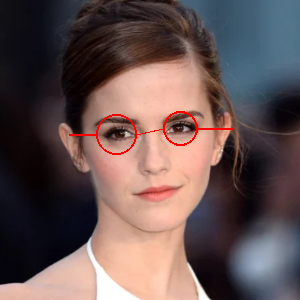

In [7]:
def getBoundingBox(e):
    return (e[0], e[1], e[0] + e[2], e[1] + e[3])

def getCenter(e):
    return (e[0] + e[2] // 2, e[1] + e[3] // 2)

def checkElementIn(e1, e2):
    if e1[0] > e2[0] and e1[1] > e2[1] and e1[0] + e1[2] < e2[0] + e2[2] and e1[1] + e1[3] < e2[1] + e2[3]:
        return True
    return False

def checkCenterIn(e1, e2):
    e1_center = getCenter(e1)
    if e2[0] + e2[2] > e1_center[0] > e2[0] and e2[1] + e2[3] > e1_center[1] > e2[1]:
        return True
    return False

def crop_resize(data, image, gray):
    #Get center by face
    faces = face_cascade.detectMultiScale(gray)
    face = faces[0]
    for i in range(1,len(faces)):
        if faces[i][2] > face[2]:
            face = faces[i]
    
    #Crop
    border = min(face[0],
                 face[1],
                 (gray.shape)[1] - face[0] - face[2],
                 (gray.shape)[0] - face[1] - face[3])
    width_diff, height_diff = face[0] - border, face[1] - border
    gray = gray[height_diff:(face[1] + face[3] + border),
                width_diff:(face[0] + face[2] + border)]
    image = image[height_diff:(face[1] + face[3] + border),
                width_diff:(face[0] + face[2] + border), :]
    
    #Resize
    side = int(re.search('(^[0-9]+)x.*', data['image size']).group(1))
    gray = cv.resize(gray, (side, side))
    image = cv.resize(image, (side, side))
    
    return image, gray

def get_face_eyes(gray):
    face = face_cascade.detectMultiScale(gray)[0]
    eyes = eye_cascade.detectMultiScale(gray)
    eyepairs = eyepair_cascade.detectMultiScale(gray)
    
    eyepair = eyepairs[0]
    for i in range(len(eyepairs)):
        if checkElementIn(eyepairs[i], face):
            eyepair = eyepairs[i]
    real_eyes = []
    for i in range(len(eyes)):
        if checkCenterIn(eyes[i], eyepair) == True:
            real_eyes.append(eyes[i])
    return face, real_eyes

def glasses(data):
    #Get Images
    image = cv.imread(dir_path + data['file name'])
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    
    b, g, r = cv.split(image)
    image = np.dstack((r, g, b))
    
    image, gray = crop_resize(data, image, gray)
    
    #Remake elements
    face, eyes = get_face_eyes(gray)
    
    #Draw glasses colorful
    pillow_image = Image.fromarray(image, mode='RGB')
    pillow_draw = ImageDraw.Draw(pillow_image)
    
    #Circles
    for i in range(len(eyes)):
        pillow_draw.ellipse(getBoundingBox(eyes[i]), outline=data['glasses color'], width=data['line width'])
    
    #Line
    left_eye, right_eye = eyes[0], eyes[1]
    if (left_eye[0] > right_eye[0]):
        swap_eye = left_eye
        left_eye = right_eye
        right_eye = swap_eye
    left_center, right_center = getCenter(left_eye), getCenter(right_eye)
    pillow_draw.line([face[0], left_center[1], left_eye[0], left_center[1]],
                     fill=data['glasses color'], width=data['line width'])
    pillow_draw.line([left_eye[0] + left_eye[2], left_center[1], right_eye[0], right_center[1]],
                     fill=data['glasses color'], width=data['line width'])
    pillow_draw.line([right_eye[0] + right_eye[2], right_center[1], face[0] + face[2], right_center[1]],
                     fill=data['glasses color'], width=data['line width'])
    
    pillow_image.save(output_dir_path + data['file name'])
    return pillow_image

glasses(row)